# Bootes master catalogue
## Preparation of IBIS data

The catalogue comes from `dmu0_IBIS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in apertude 4 ($1.2 * \sqrt{2}$ arcsec = 1.7 arcsec).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-15 13:49:16.811795


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates, \
                                            nb_plot_mag_ap_evol, nb_plot_mag_vs_apcor
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, aperture_correction

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "ibis_ra"
DEC_COL = "ibis_dec"

## I - Column selection

### I.i - Aperture correction


In [4]:
# Pristine IBIS catalogue
orig_ibis = Table.read("../../dmu0/dmu0_IBIS/data/IBIS_MLselected_20160801.fits")

In [5]:
# The website says the aperture correction values can be found in the catalogue header 
# http://r2.sdm.noao.edu/nsa/NEWFIRM_NDWFS.html
# These can not be found so we do our own curve of growth analysis
#j_ap_to_tot = 0.
#h_ap_to_tot = 0.
#k_ap_to_tot = 0.
#newfirm_ap_to_tot = {
#    'j': j_ap_to_tot,
#    'h': h_ap_to_tot,
#    'k': k_ap_to_tot
#    
#}

In [6]:

bands = ["j", "h", "k"]
apertures = ["1", "2", "3", "4",  "5", "6", "7", "8", "9", "10", "11", "12", "13"]  

magnitudes = {}
stellarities = {}

for band in bands:
    magnitudes[band] = np.array(
        [orig_ibis["{}_mag_aper_{}".format(band, aperture )] for aperture in apertures]
    )

    stellarities[band] = np.array(orig_ibis["{}_class_star".format(band)])
    
    # Some sources have an infinite magnitude
    mask = np.isclose(magnitudes[band], 99.)
    magnitudes[band][mask] = np.nan

    
mag_corr = {}

## J

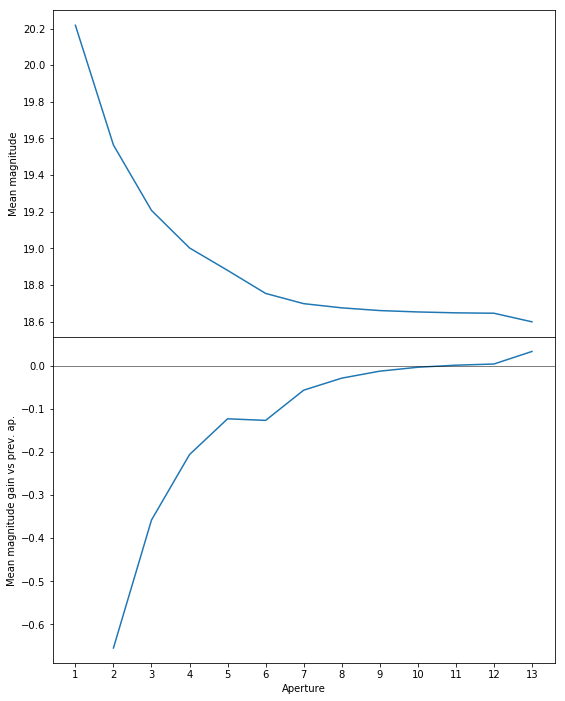

In [7]:
nb_plot_mag_ap_evol(magnitudes['j'], stellarities['j'], labels=apertures)

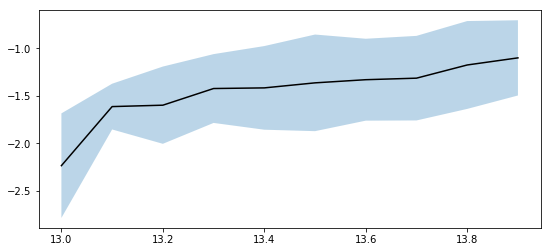

In [8]:
nb_plot_mag_vs_apcor(orig_ibis['j_mag_aper_2'], orig_ibis['j_mag_aper_10'], stellarities['j'])

In [9]:
# Aperture correction
mag_corr['j'], num, std = aperture_correction(
    orig_ibis['j_mag_aper_2'], orig_ibis['j_mag_aper_10'], 
    stellarities['j'],
    mag_min=13.0, mag_max=14.0)
print("Aperture correction for j band:")
print("Correction: {}".format(mag_corr['j']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for j band:
Correction: -1.3177995681762695
Number of source used: 768
RMS: 0.4462176013078398


## H

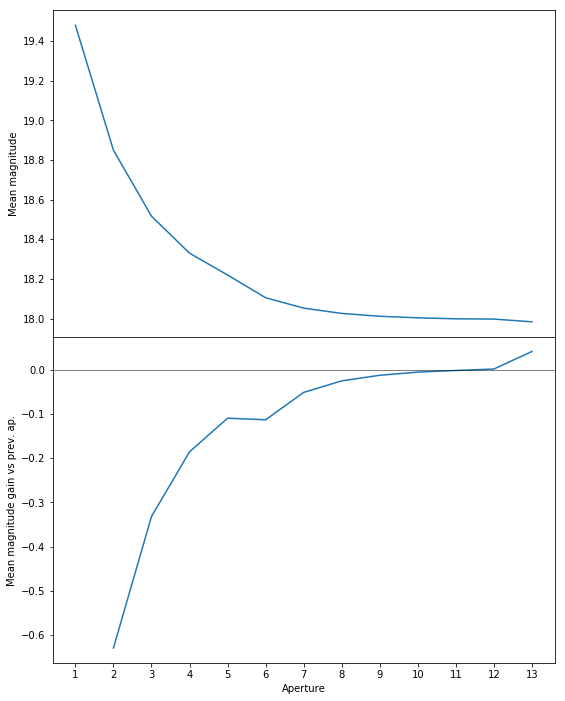

In [10]:
nb_plot_mag_ap_evol(magnitudes['h'], stellarities['h'], labels=apertures)

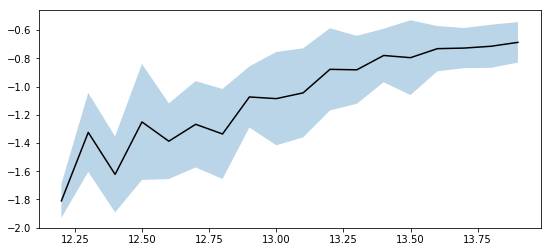

In [11]:
nb_plot_mag_vs_apcor(orig_ibis['h_mag_aper_2'], orig_ibis['h_mag_aper_10'], stellarities['h'])

In [12]:
# Aperture correction
mag_corr['h'], num, std = aperture_correction(
    orig_ibis['h_mag_aper_2'], orig_ibis['h_mag_aper_10'], 
    stellarities['h'],
    mag_min=13.0, mag_max=14.0)
print("Aperture correction for h band:")
print("Correction: {}".format(mag_corr['h']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for h band:
Correction: -0.7972502708435059
Number of source used: 1417
RMS: 0.24215363892231234


## K

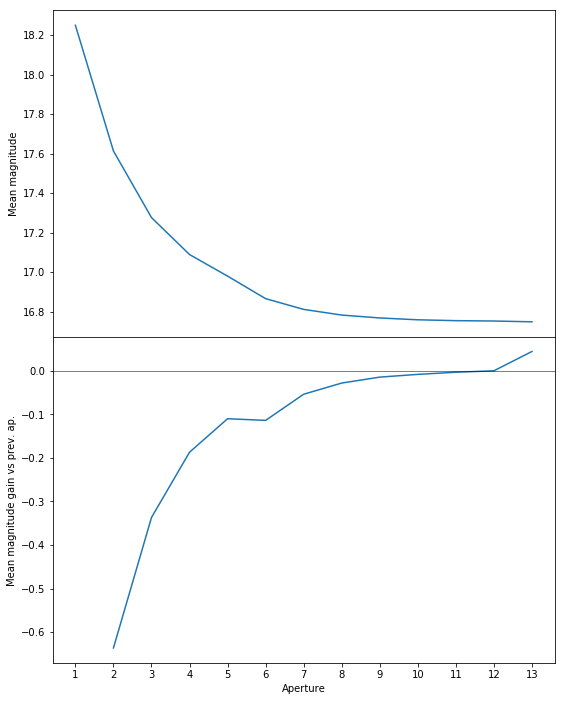

In [13]:
nb_plot_mag_ap_evol(magnitudes['k'], stellarities['k'], labels=apertures)

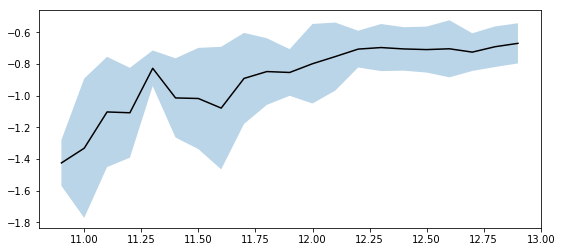

In [14]:
nb_plot_mag_vs_apcor(orig_ibis['k_mag_aper_2'], orig_ibis['k_mag_aper_10'], stellarities['k'])

In [15]:
# Aperture correction
mag_corr['k'], num, std = aperture_correction(
    orig_ibis['k_mag_aper_2'], orig_ibis['k_mag_aper_10'], 
    stellarities['k'],
    mag_min=11.5, mag_max=12.5)
print("Aperture correction for k band:")
print("Correction: {}".format(mag_corr['k']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for k band:
Correction: -0.7923002243041992
Number of source used: 556
RMS: 0.2164772172129723


### 1.ii - Vega-like to AB

In [16]:
## Vega to AB
# http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=NOAO
j_vega_to_ab   =  -2.5*np.log10(1559.06 / 3631.) 
h_vega_to_ab   =  -2.5*np.log10(1044.7 / 3631.) 
k_vega_to_ab   =  -2.5*np.log10( 677.1/ 3631.) 

#Vega correction - the magnitudes are nto in true Vega and have to be converted first
#Magnitudes also need a minor correction to turn them into Vega
# http://r2.sdm.noao.edu/nsa/NEWFIRM_NDWFS.html
j_newfirm_to_vega = -0.056
h_newfirm_to_vega = -0.007
k_newfirm_to_vega = 0.

newfirm_to_ab = {
    'j': j_newfirm_to_vega + j_vega_to_ab,
    'h': h_newfirm_to_vega + h_vega_to_ab,
    'k': k_newfirm_to_vega + k_vega_to_ab,
}

In [17]:
imported_columns = OrderedDict({
        'internal_id': "ibis_id",
        'alpha_j2000': "ibis_ra",
        'delta_j2000': "ibis_dec",
        'k_class_star':  "ibis_stellarity",
        'j_mag_auto': "m_newfirm_j", 
        'j_magerr_auto': "merr_newfirm_j", 
        'j_mag_aper_3': "m_ap_newfirm_j", 
        'j_magerr_aper_3': "merr_ap_newfirm_j",
            'h_mag_auto': "m_newfirm_h", 
        'h_magerr_auto': "merr_newfirm_h", 
        'h_mag_aper_3': "m_ap_newfirm_h", 
        'h_magerr_aper_3': "merr_ap_newfirm_h",
            'k_mag_auto': "m_newfirm_k", 
        'k_magerr_auto': "merr_newfirm_k", 
        'k_mag_aper_3': "m_ap_newfirm_k", 
        'k_magerr_aper_3': "merr_ap_newfirm_k"
    })


catalogue = Table.read("../../dmu0/dmu0_IBIS/data/IBIS_MLselected_20160801.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [18]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        mask = (catalogue[col] <= 0.) | (catalogue[col] > 90. )
        catalogue[col][mask] = np.nan
       
        
        #Vega to AB
        catalogue[col] = catalogue[col] + newfirm_to_ab[col[-1]]
        
        #Aperture correction
        if "ap" in col:
            catalogue[col] = catalogue[col] + mag_corr[col[-1]] # newfirm_ap_to_tot[col[-1]]
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [19]:
catalogue[:10].show_in_notebook()

idx,ibis_id,ibis_ra,ibis_dec,ibis_stellarity,m_newfirm_j,merr_newfirm_j,m_ap_newfirm_j,merr_ap_newfirm_j,m_newfirm_h,merr_newfirm_h,m_ap_newfirm_h,merr_ap_newfirm_h,m_newfirm_k,merr_newfirm_k,m_ap_newfirm_k,merr_ap_newfirm_k,f_newfirm_j,ferr_newfirm_j,flag_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,f_newfirm_h,ferr_newfirm_h,flag_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,f_newfirm_k,ferr_newfirm_k,flag_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k
,,deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,
0,P10_1235,216.4152319,32.4143448,0.43,21.3015,0.1225,21.2113,0.10869999975,21.0379,0.207000002265,21.3696,0.1607,20.4584,0.245,20.9118,0.2081,10.9496,1.2354027217,False,11.8981,1.19119229147,13.9587,2.66128286968,False,10.2836,1.52207686342,23.8027,5.37116231499,False,15.6772,3.00479916741
1,P10_972,216.4317798,32.4011048,0.98,16.9466,0.0043,16.5583,0.00600000005215,16.8344,0.00669999979436,16.3625,0.0054,17.0994,0.0148,16.6798,0.0088,604.445,2.39387202892,False,864.324,4.77643280251,670.263,4.13614299143,False,1035.11,5.14819520758,525.081,7.15753866825,False,772.799,6.26361570321
2,P10_913,216.4505835,32.3928767,0.3,21.7077,0.1712,21.3913,0.130099996924,21.4801,0.295100003481,21.2365,0.1426,20.8945,0.3589,21.1939,0.2775,7.53211,1.18767019521,False,10.0804,1.2078961805,9.28892,2.52470131267,False,11.6248,1.5267943365,15.9289,5.26545320636,False,12.09,3.09005134568
3,P10_887,216.4469076,32.3944784,0.97,17.3714,0.0055,16.9709,0.00730000017211,17.2624,0.00899999961257,16.7882,0.0068,17.5043,0.0199,17.0696,0.0109,408.73,2.07049764867,False,591.066,3.97406367176,451.903,3.74596247156,False,699.367,4.38015677501,361.632,6.62819316203,False,539.693,5.41812100564
4,P10_840,216.4557157,32.3901299,0.12,20.4973,0.0816,20.6415,0.0710999965668,20.407,0.156299993396,20.8858,0.106,20.8374,0.4767,20.4753,0.1418,22.9655,1.72600557853,False,20.1092,1.3168643204,24.9577,3.59285745897,False,16.057,1.56764282474,16.7891,7.37135677755,False,23.4351,3.06068277969
5,P10_764,216.4687838,32.3832323,0.82,20.7298,0.0627,20.475,0.062199998647,20.3973,0.0953999981284,20.1119,0.0547,20.6064,0.2321,19.9991,0.0919,18.5386,1.07058122703,False,23.4421,1.34295714113,25.1817,2.21263079536,False,32.7511,1.65001703008,20.7695,4.43993928493,False,36.3368,3.07565276853
6,P10_787,216.4711519,32.3870208,0.95,18.0826,0.009,17.6951,0.0108000002801,18.0893,0.0166999995708,17.6263,0.0103,18.5028,0.0458,18.0642,0.0205,212.303,1.75984814996,False,303.359,3.01756537198,211.001,3.24546695438,False,323.196,3.06604556972,144.167,6.08146254672,False,215.927,4.07696287584
7,P10_813,216.4728109,32.386109,0.38,21.9928,0.1539,21.5113,0.140300005674,22.2047,0.394300013781,21.5669,0.1884,21.7489,0.5315,21.5207,0.37,5.79265,0.821090998124,False,9.02562,1.16630078352,4.76568,1.73072224894,False,8.57482,1.48792736836,7.25148,3.54981228679,False,8.94761,3.04918873553
8,P10_988,216.4564565,32.3982095,0.8,20.2534,0.048,20.0477,0.0452000014484,19.6756,0.0595000013709,19.5507,0.0368,19.528,0.1027,19.3162,0.0531,28.7499,1.2710224546,False,34.747,1.44654359589,48.9514,2.68261050038,False,54.9168,1.86135437107,56.0773,5.30436088738,False,68.1563,3.33331490619


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [20]:
SORT_COLS = ['merr_ap_newfirm_j', 'merr_ap_newfirm_h', 'merr_ap_newfirm_k']
FLAG_NAME = 'ibis_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 389594 sources.
The cleaned catalogue has 389594 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [21]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Bootes.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

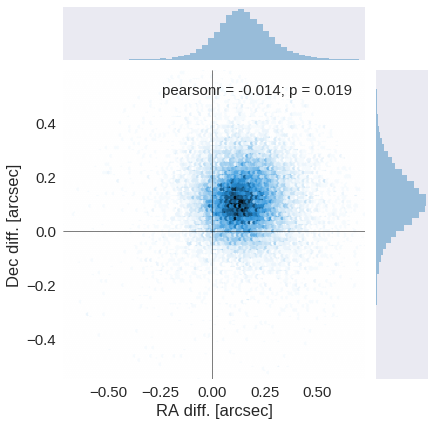

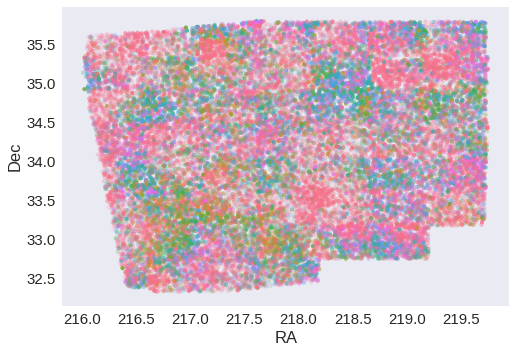

In [22]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [23]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.14042821500197533 arcsec
Dec correction: -0.11290194161972522 arcsec


In [24]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

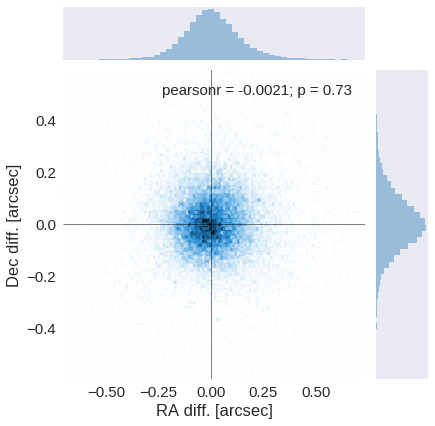

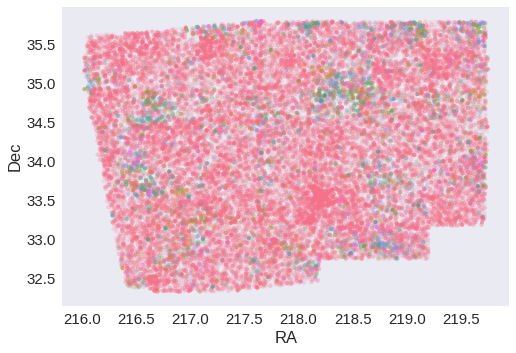

In [25]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [26]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [27]:
GAIA_FLAG_NAME = "ibis_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

28013 sources flagged.


# V - Saving to disk

In [28]:
catalogue.write("{}/IBIS.fits".format(OUT_DIR), overwrite=True)